# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# HYPERPARAMS
num_epochs = 20
batch_size = 128
lr = 0.01

# CONSTANTS
NUM_CLASSES = 10
DATA_MEAN = (0.1307,)
DATA_STD = (0.3081,)

# cuda availability
cuda_available = torch.cuda.is_available()
device = "cuda" if cuda_available else "cpu"

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       # transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       # transforms.RandomAffine(degrees=(-7.0, 7.0),translate=(0.1,0.1), scale=(0.9, 1.1), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(DATA_MEAN, DATA_STD) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(DATA_MEAN, DATA_STD)
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, title: str="Class label"):
    """
    This function essentially takes in normalized tensors and the
    Un-normalize them and display the image as output.

    Args:
    ----
    image: Image which we want to plot.
    title: Label for that image.
    """
    image = image.numpy().transpose((1, 2, 0)) # (C, H, W) --> (H, W, C)
    # Convert mean and std to numpy array
    mean = np.asarray(DATA_MEAN)
    std = np.asarray(DATA_STD)
    # unnormalize the image
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    print(title)
    fig = plt.figure() # Create a new figure
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111)
    ax.axis("off") # Sqitch off the axis
    ax.imshow(image)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


['6', '1', '4', '0', '7', '1', '8', '9', '0', '1', '2', '4', '2', '5', '9', '3', '9', '5', '1', '4', '1', '1', '3', '3', '2', '4', '3', '7', '8', '8', '1', '1', '4', '5', '4', '5', '0', '1', '0', '0', '7', '3', '7', '5', '0', '4', '1', '5', '3', '7', '9', '4', '6', '2', '6', '8', '5', '1', '5', '0', '0', '0', '3', '9', '9', '2', '4', '9', '2', '0', '3', '6', '5', '1', '9', '8', '9', '3', '1', '6', '6', '1', '0', '3', '8', '0', '9', '8', '5', '3', '3', '0', '8', '4', '1', '9', '7', '0', '2', '4', '8', '4', '7', '8', '5', '6', '1', '8', '5', '8', '3', '5', '0', '3', '0', '4', '7', '4', '3', '8', '4', '7', '1', '5', '0', '5', '5', '7']


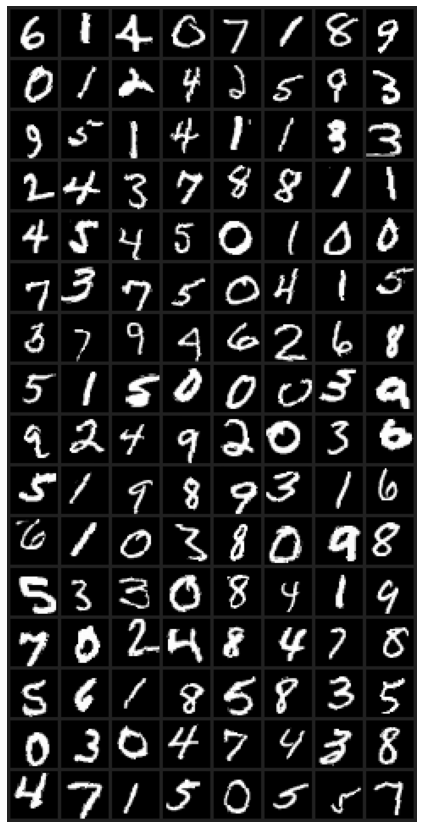

In [ ]:
# Iteratre over and get 1 batch of training data
data, targets = next(iter(train_loader))

# make_grid takes all tensors(batch) and joins them into a single big tensor image (almost)
batch_grid = torchvision.utils.make_grid(data) 

display_image(batch_grid, title=[str(cls.item()) for cls in targets])

# The model
Let's start with the model we first saw

In [ ]:
# ------99.2 /8.8k
import torch.nn.functional as F
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=4, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 28
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6
               
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        self.classifier = nn.Linear(16, 10)

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        # x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)


        x = x.view(-1, 16)
        x = self.classifier(x)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 4, 24, 24]              64
        MaxPool2d-10            [-1, 4, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             288
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.04746580496430397 Batch_id=468 Accuracy=93.25: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0755, Accuracy: 9772/10000 (97.72%)

EPOCH: 1


Loss=0.1638844609260559 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:26<00:00, 17.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0949, Accuracy: 9722/10000 (97.22%)

EPOCH: 2


Loss=0.0034625399857759476 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.1472635269165039 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9838/10000 (98.38%)

EPOCH: 4


Loss=0.17425431311130524 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9826/10000 (98.26%)

EPOCH: 5


Loss=0.07239090651273727 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.018583962693810463 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.001955342711880803 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.015738973394036293 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.05215385928750038 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.0019689060281962156 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.01409715786576271 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.03173777461051941 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:26<00:00, 17.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.0021624411456286907 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.0014810304855927825 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]



Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

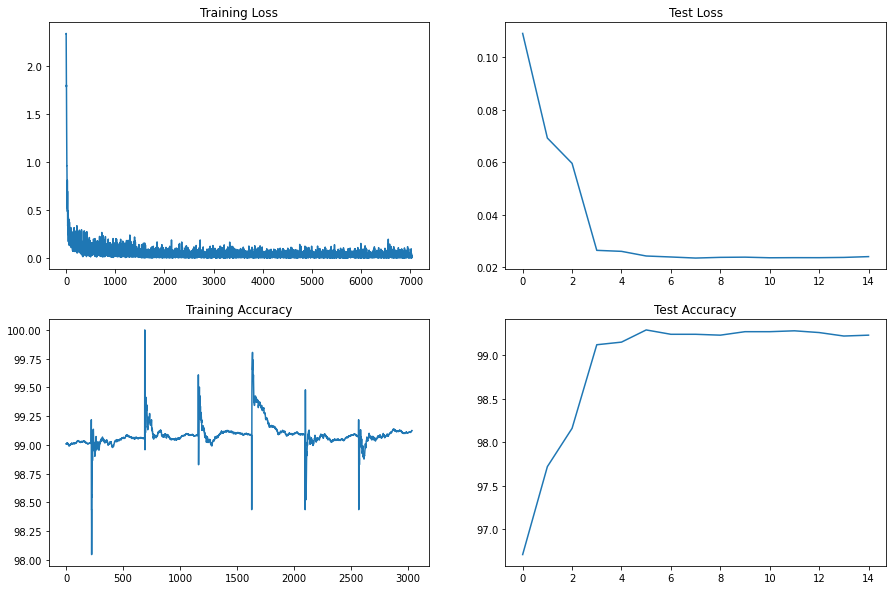

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")